# Hydrostatic equilibrum

Here we setup an isothermal hydrostatic atmosphere and look to see how well the code maintains HSE.

In [1]:
from ppmpy.euler import Euler
from ppmpy.gravity import constant_gravity
import numpy as np

In [2]:
def hse(grid, v, gamma, U, params):
    rho_base = params["base_density"]
    pres_base = params["base_pressure"]
    g = params["g_const"]

    # we will assume we are isothermal and constant composition.  In that case,
    # p/rho = constant
    A = pres_base / rho_base
    
    # we will discretize HSE as second-order
    # p_{i+1} = p_i + dx / 2 (rho_i + rho_{i+1} g
    # but we can write p_{i+1} = A rho_{i+1} and solve for rho_{i+1}
    
    p = grid.scratch_array()
    rho = grid.scratch_array()

    # we want the base conditions to be at the lower boundary.  We will
    # set the conditions in the first zone center from the analytic expression:
    # P = P_base e^{-z/H}
    
    H = pres_base / rho_base / np.abs(g)
    
    p[grid.lo] = pres_base * np.exp(-grid.x[grid.lo] / H)
    rho[grid.lo] = rho_base * np.exp(-grid.x[grid.lo] / H)

    for i in range(grid.lo+1, grid.hi+1):
        rho[i] = (p[i-1] + 0.5 * grid.dx * rho[i-1] * g) / (A - 0.5 * grid.dx * g)
        p[i] = A * rho[i]

    # now check:
    max_err = 0.0
    for i in range(grid.lo+1, grid.hi+1):
        dpdr = (p[i] - p[i-1])/grid.dx
        rhog = 0.5 * (rho[i] + rho[i-1]) * g
        err = np.abs(dpdr - rhog) / np.abs(rhog)
        max_err = max(max_err, err)

    #print(f"max err = {max_err}")
    
    # now fill the conserved variables
    U[:, v.urho] = rho[:]
    U[:, v.umx] = 0.0
    U[:, v.uener] = p[:] / (gamma - 1.0)

## Boundary conditions

Let's look at what the reflecting BCs are doing

In [3]:
params = {"base_density": 1.0, "base_pressure": 1.0, "g_const": -1.0}
e = Euler(32, 0.5, init_cond=hse, grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect",
          params=params)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

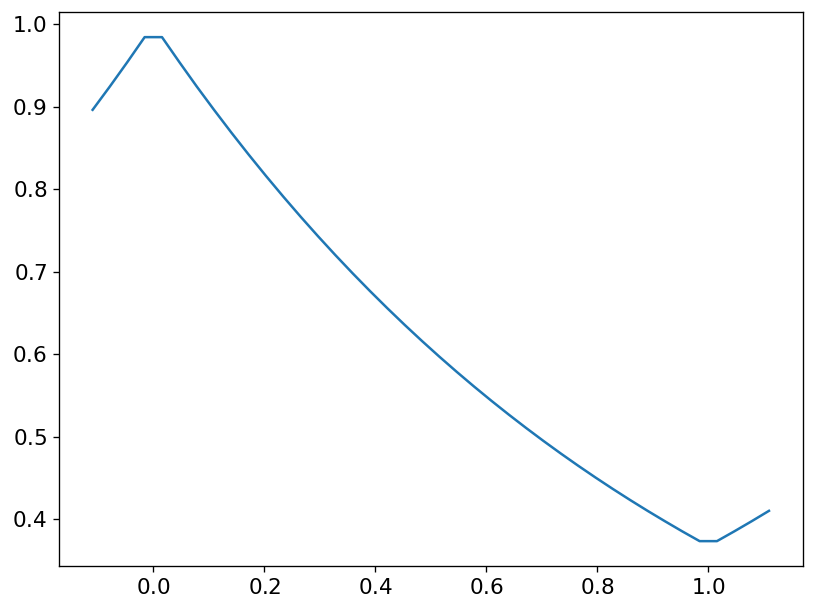

In [15]:
fig, ax = plt.subplots()
ax.plot(e.grid.x, e.U[:, 0])

## Convergence testing

In [26]:
simulations = []
for nx in [32, 64, 128, 256, 512]:
    dt = 0.015625 * (32 / nx)
    e = Euler(nx, 0.5, fixed_dt=dt, init_cond=hse, grav_func=constant_gravity,
              use_limiting=True, use_flattening=True,
              use_hse_reconstruction=True,
              bc_left_type="reflect", bc_right_type="reflect", params=params)
    e.evolve(0.5, verbose=False)
    simulations.append(e)

In [27]:
from itertools import pairwise
ivar = 0

In [28]:
for coarse, fine in pairwise(simulations):
    _, cd = fine.grid.coarsen(fine.U[:, ivar])
    err = coarse.grid.norm(coarse.U[:, ivar] - cd)
    print(f"{fine.grid.nx:3d} -> {coarse.grid.nx:3d} : {err}")

 64 ->  32 : 3.6537626526361884e-05
128 ->  64 : 9.2087123523224e-06
256 -> 128 : 2.3117807006001918e-06
512 -> 256 : 5.794725188242857e-07


In [29]:
for s in simulations:
    init = s.grid.scratch_array(nc=3)
    hse(s.grid, s.v, s.gamma, init, params)
    print(f"{s.grid.nx:3d} : {s.grid.norm(init[:, ivar] - s.U[:, ivar]) }")

 32 : 1.5642584519965996e-05
 64 : 3.955429302832413e-06
128 : 9.944136877953302e-07
256 : 2.5011318512955466e-07
512 : 6.259701005320183e-08


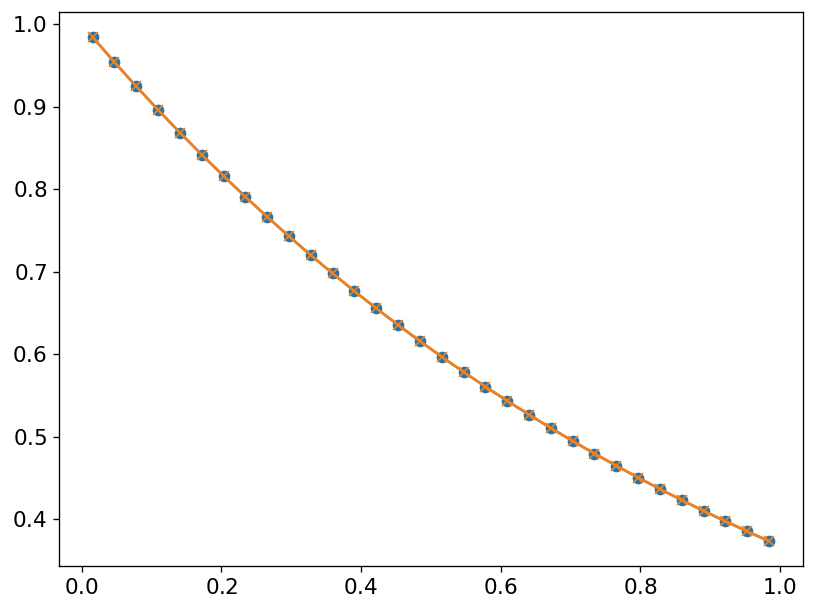

In [30]:
s = simulations[0]
init = s.grid.scratch_array(nc=3)
hse(s.grid, s.v, s.gamma, init, params)

fig, ax = plt.subplots()
ax.plot(s.grid.x[s.grid.lo:s.grid.hi+1], init[s.grid.lo:s.grid.hi+1, ivar], marker="o")
ax.plot(s.grid.x[s.grid.lo:s.grid.hi+1], s.U[s.grid.lo:s.grid.hi+1, ivar], marker="x")